# Using Encodec to extract the latent feature

In [1]:
import torch
from torch import Tensor, nn
import torchaudio
from transformers import EncodecModel
import os
import glob
import tqdm
device = 'cuda:0'
max_len = 409600

/home/kinwai/miniforge3/envs/diff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
encodec_model = EncodecModel.from_pretrained("facebook/encodec_24khz").to(device)

/home/kinwai/miniforge3/envs/diff/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/kinwai/miniforge3/envs/diff/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
upsampler = torchaudio.transforms.Resample(16000, 24000)

In [4]:
encoder = encodec_model.get_encoder()
decoder = encodec_model.get_decoder()

In [5]:
def wav2embedding(audio_dir='/tss/yurii/chamber-ensemble-generator/toy_dataset/violin_swapped'):
    # load all audio files from /tss/yurii/chamber-ensemble-generator/toy_dataset/violin_swapped
    embeddings = []
    for filename in tqdm.tqdm(glob.glob(os.path.join(audio_dir, '*', '*.wav'))):
        waveform, sample_rate = torchaudio.load(filename)
        upsampled_waveform = upsampler(waveform)
        # if waveform is longer than max_len, cut it, otherwise pad it
        if upsampled_waveform.shape[1] > max_len:
            upsampled_waveform = upsampled_waveform[:, :max_len]
        else:
            upsampled_waveform = torch.nn.functional.pad(upsampled_waveform, (0, max_len - upsampled_waveform.shape[1]))
        embedding = encoder(upsampled_waveform.unsqueeze(0).to(device))
        embeddings.append(embedding.cpu().detach())   
    return torch.cat(embeddings, dim=0)

In [6]:
violin_embeddings = wav2embedding('/tss/yurii/chamber-ensemble-generator/toy_dataset/violin_swapped')
flute_embeddings = wav2embedding('/tss/yurii/chamber-ensemble-generator/toy_dataset/flute')

100%|██████████| 37/37 [00:01<00:00, 27.37it/s]


In [7]:
violin_embeddings[0]

tensor([[ 1.1295,  1.9908,  3.3026,  ...,  0.4151,  0.1219,  1.0811],
        [10.0129,  9.7310, 10.5637,  ..., 10.4062, 10.7847, 10.1498],
        [-3.9124, -3.3667, -3.4599,  ..., -3.1879, -2.4217, -2.7793],
        ...,
        [ 0.6406,  0.0718,  0.7198,  ..., -0.3987, -0.0404, -0.2345],
        [-2.2240, -1.1301,  0.3971,  ..., -0.9994, -1.3462, -1.3446],
        [ 1.4385,  1.6357,  1.5927,  ...,  0.3234,  0.7119,  0.5941]])

In [8]:
violin_audio_0 = decoder(violin_embeddings[0].unsqueeze(0).to(device))
flute_audio_0 = decoder(flute_embeddings[0].unsqueeze(0).to(device))

violin_audio_10 = decoder(violin_embeddings[10].unsqueeze(0).to(device))
flute_audio_10 = decoder(flute_embeddings[10].unsqueeze(0).to(device))

# Check if the audio pair is correct

In [13]:
# listen to audio usiny IPython
from IPython.display import Audio
Audio(violin_audio_0.squeeze().cpu().detach().numpy(), rate=24000)


In [14]:
Audio(flute_audio_0.squeeze().cpu().detach().numpy(), rate=24000)

In [15]:
Audio(violin_audio_10.squeeze().cpu().detach().numpy(), rate=24000)

In [16]:
Audio(flute_audio_10.squeeze().cpu().detach().numpy(), rate=24000)

# Define Translator

In [18]:
from latentis.space import LatentSpace
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from latentis import transform
from latentis.transform.dim_matcher import ZeroPadding
from latentis.transform._abstract import Estimator
from latentis.transform.translate import Translator, MatrixAligner
from latentis.transform.translate.functional import sgd_affine_align_state, svd_align_state
from latentis.transform.base import StandardScaling

translator = Translator(
    aligner=MatrixAligner(name="svd_aligner", align_fn_state=svd_align_state),
    x_transform=transform.StandardScaling(),
    y_transform=transform.StandardScaling(),
    dim_matcher=ZeroPadding()
)

# Fit Translator

In [19]:
translator.fit(x=violin_embeddings.mean(-1), y=flute_embeddings.mean(-1))

Translator(
  (x_transform): name=centering, reverse_fn=standard_scaling_inverse)
  (y_transform): name=centering, reverse_fn=standard_scaling_inverse)
  (aligner): MatrixAligner()
  (dim_matcher): ZeroPadding()
)

# Latent Translation

In [20]:
x_transformed, y_transformed = translator.transform(x=violin_embeddings.mean(-1), y=flute_embeddings.mean(-1)) 

In [21]:
x_transformed.shape, y_transformed.shape

(torch.Size([37, 128]), torch.Size([37, 128]))

# Visualization

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
# create the same PCA model for both spaces
pca.fit(torch.cat((violin_embeddings.mean(-1), flute_embeddings.mean(-1)), dim=0).numpy())

PCA(n_components=2)

In [23]:
space1_pca = pca.transform(violin_embeddings.mean(-1))
space2_pca = pca.transform(flute_embeddings.mean(-1))

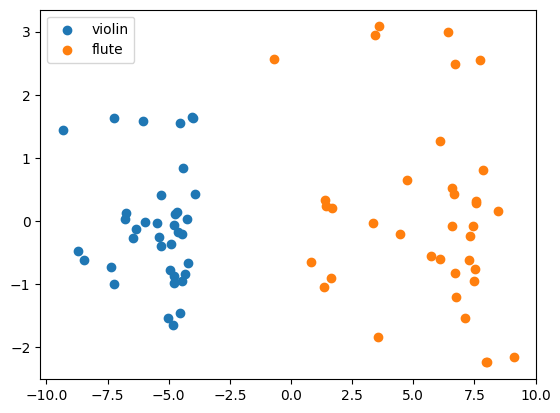

In [24]:
# plot space1_pca and space2_pca in a 2D plot
plt.scatter(space1_pca[:, 0], space1_pca[:, 1], label="violin")
plt.scatter(space2_pca[:, 0], space2_pca[:, 1], label="flute")
plt.legend()
plt.title('original space')

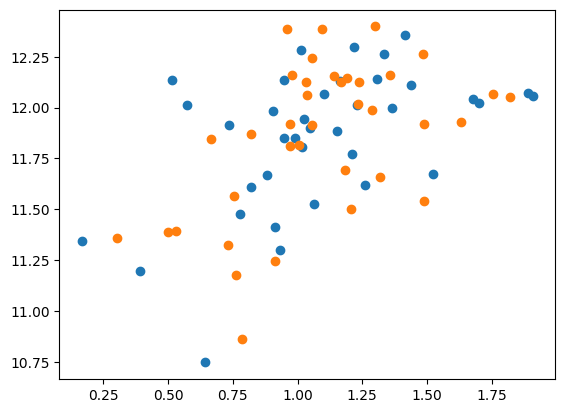

In [25]:
# plot x_transformed and y_transformed in a 2D plot
plt.scatter(x_transformed[:, 0], x_transformed[:, 1], label="violin_transformed")
plt.scatter(y_transformed[:, 0], y_transformed[:, 1], label="flute_transformed")
plt.title('transformed space')